# Overview

[TASK: T347060](https://phabricator.wikimedia.org/T347060)

**Goal**
- To analyse [Echo notifications](https://www.mediawiki.org/wiki/Notifications) sent to registered users when they become eligible to access [The Wikipedia Library](https://meta.wikimedia.org/wiki/The_Wikipedia_Library), and specifically to check if there has been any outage.

**Data source**
- [echo_event](https://www.mediawiki.org/wiki/Extension:Echo/echo_event_table) and [echo_notification](https://www.mediawiki.org/wiki/Special:MyLanguage/Extension:Echo/echo_notification_table)

**Summary**<br>
- Although, the overall number notifications sent has decreased over time (which is an expected trend), there hasn't been any significant change in the last few weeks/months. 
- During the last six months, the average number of daily notifications sent is 30.

# Data-Gathering

In [52]:
import pandas as pd
import wmfdata as wmf

from IPython.display import clear_output
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

## query

In [29]:
# canonical data for wikis
cd_wikis = pd.read_csv('https://raw.githubusercontent.com/wikimedia-research/canonical-data/master/wiki/wikis.tsv', sep='\t')

# public, open and content wikis
content_db_groups = ['commons', 'mediawiki', 'meta', 'species', 'wikibooks', 'wikidata', 
                     'wikifunctions', 'wikinews', 'wikipedia', 'wikiquote', 'wikisource', 
                     'wikiversity', 'wikivoyage', 'wiktionary']
open_content_wikis = cd_wikis.query("""(status == 'open') & (visibility == 'public') & (editability == 'public') & (database_group == @content_dbs)""")

In [43]:
%%time

warnings.filterwarnings('ignore')

query = """
SELECT 
    event_id,
    event_agent_id,
    DATE(notification_timestamp) AS notification_timestamp,
    DATE(notification_read_timestamp) AS notification_read_timestamp
FROM 
    echo_event ee
    JOIN echo_notification en 
    ON ee.event_id = en.notification_event
WHERE 
    event_type = 'twl-eligible'
"""

twl_echo_logs = pd.DataFrame()
for db in open_content_wikis.database_code.unique():
    wiki_logs = wmf.mariadb.run(query, dbs=db, use_x1=True)
    wiki_logs['wiki_db'] = db
    twl_echo_logs = pd.concat([twl_echo_logs, wiki_logs], ignore_index=True)

CPU times: user 7.88 s, sys: 753 ms, total: 8.64 s
Wall time: 1min 12s


In [132]:
# convert timestamps

twl_echo_logs = (
    twl_echo_logs
    .assign(
        notification_timestamp = pd.to_datetime(twl_echo_logs['notification_timestamp']),
        notification_read_timestamp = pd.to_datetime(twl_echo_logs['notification_read_timestamp'])
    )
)

In [135]:
# group by wiki, day
daily_logs_by_wiki = twl_echo_logs.groupby(['wiki_db', 'notification_timestamp']).agg({'event_id': 'count'}).reset_index().rename({'event_id': 'notifications_sent'}, axis=1)

# group by data
daily_logs = twl_echo_logs.query("""wiki_db != 'enwiki'""").groupby('notification_timestamp').agg({'event_id': 'count'}).reset_index().rename({'event_id': 'notifications_sent'}, axis=1)
daily_logs = (
    daily_logs.assign(
        month = pd.DatetimeIndex(daily_logs['notification_timestamp']).month,
        year = pd.DatetimeIndex(daily_logs['notification_timestamp']).year
    )
)

# Analysis

## Number of notifications sent - graph

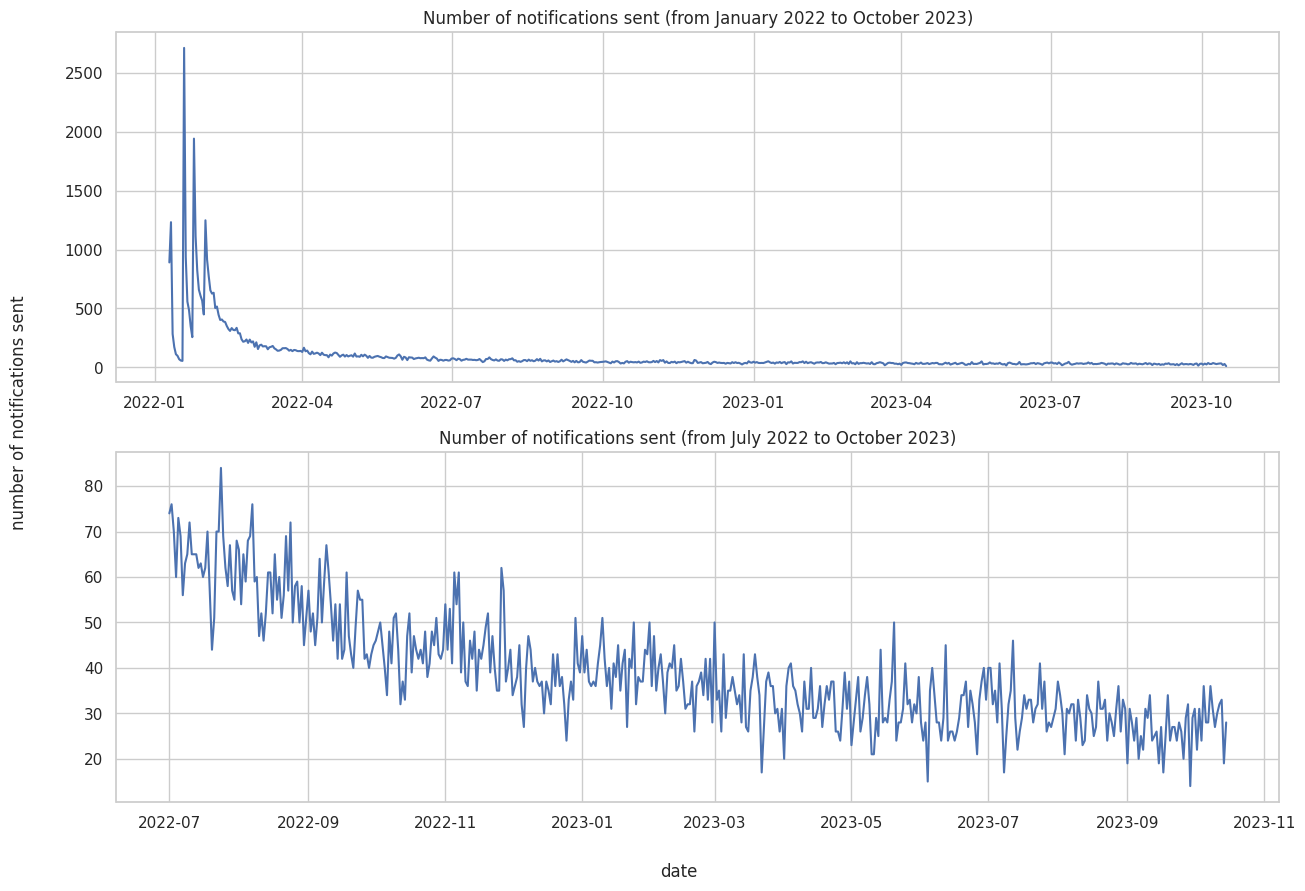

In [126]:
date_bounds = [pd.to_datetime('2022-07-01'), pd.to_datetime('2023-10-15')]

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.lineplot(daily_logs, x='notification_timestamp', y='notifications_sent', ax=axes[0])
axes[0].set_title('Number of notifications sent (from January 2022 to October 2023)')
axes[0].set_xlabel("")
axes[0].set_ylabel("")

sns.lineplot(daily_logs.query("""@date_bounds[0] <= notification_timestamp <= @date_bounds[1]"""), x='notification_timestamp', y='notifications_sent', ax=axes[1])
axes[1].set_title('Number of notifications sent (from July 2022 to October 2023)')
axes[1].set_xlabel("")
axes[1].set_ylabel("")

fig.text(0.5, 0.04, 'date', ha='center', va='center')
fig.text(0.06, 0.5, 'number of notifications sent', ha='center', va='center', rotation='vertical')

fig.show()

## Average daily number of notifications sent by month

In [139]:
avg_notifications = round(daily_logs.groupby(['year', 'month']).agg({'notifications_sent': 'mean'})).astype({'notifications_sent': int})
avg_notifications.reset_index()

,year,month,notifications_sent
0,2022,1,656
1,2022,2,433
2,2022,3,164
3,2022,4,113
4,2022,5,91
5,2022,6,72
6,2022,7,65
7,2022,8,58
8,2022,9,50
9,2022,10,44
